# CLV Calculation

This notebook will demonstrate the 2 approaches that we use in calculating Customer Lifetime Value (CLV). 

### Pre-processing

In [1]:
#Import library
import numpy as np
import pandas as pd
import lifetimes

In [2]:
#load dataset 
summary = pd.read_csv('DMEFExtractSummaryV01.csv')
orders = pd.read_csv('DMEFExtractOrdersV01.csv')
contacts = pd.read_csv('DMEFExtractContactsV01.csv')
lines = pd.read_csv('DMEFExtractLinesV01.csv')

In [3]:
#clean the lines data
lines["OrderDate"] = lines["OrderDate"].astype(str)
lines["Year"] = lines["OrderDate"].str.slice(stop=4)
lines["Year"] = pd.to_numeric(lines["Year"])
lines_summary = lines.groupby(["Cust_ID","OrderNum", "Year"],as_index=False)['LineDollars'].sum()
data_clv = orders.merge(lines_summary,on=["Cust_ID","OrderNum"],how="left")
data_clv['Order_date'] = pd.to_datetime(data_clv['OrderDate'], format='%Y%m%d')
maxdate = data_clv['Order_date'].dt.date.max()
mindate = data_clv['Order_date'].dt.date.min()
unique_cust = data_clv['Cust_ID'].nunique()
tot_sales = data_clv['LineDollars'].sum()
avg_sales = data_clv['LineDollars'].mean()

print(f"The Time range of transactions is: {mindate} to {maxdate}")
print(f"Total number of unique customers: {unique_cust}")
print(f"Total Sales for the period: {tot_sales}")
print(f"Average Sales for the period: {avg_sales}")

The Time range of transactions is: 2001-01-01 to 2008-01-01
Total number of unique customers: 100051
Total Sales for the period: 17219547.900000002
Average Sales for the period: 71.34087873376829


### Historical approach: Cohort Model

This approach calculates CLV using historical data by cohorts, which are split by year of initial transaction. First, we will find the count of customers who make a number of transactions over the years, then the revenue that they generated. We can then calculate the retention rate, which varies across the years, and the average revenue per customer. These values, combined with the interest rate and the profit margins, will allow us to compute the CLV for our customer.

In [4]:
#create years vs number of orders table
def gen_trans(start_year):
    lines_copy = lines.copy()
    lines_copy = lines_copy[["Cust_ID", "Year"]].groupby(["Cust_ID"]).agg('min')
    lines_copy = lines_copy.reset_index()
    lines_copy = lines_copy["Cust_ID"].loc[lines_copy["Year"] == start_year]

    cust_list = lines_copy.unique()

    lines_copy = lines.copy()
    lines_copy = lines_copy[lines_copy["Cust_ID"].isin(cust_list)]
    lines_copy = lines_copy[["Cust_ID", "Year", "OrderNum"]].groupby(["Cust_ID", "Year"]).count()
    lines_copy = lines_copy.reset_index()
    
    lines_copy = lines_copy.groupby(["Year", "OrderNum"]).count()
    lines_copy.index.rename(["Year", "OrderNum"],  inplace=True)
    lines_copy = lines_copy["Cust_ID"].unstack(["Year"])
    lines_copy = lines_copy.fillna(0)

    return lines_copy

In [5]:
#create years vs total revenue table
def gen_rev(start_year, margin):
    lines_copy = lines.copy()
    lines_copy = lines_copy[["Cust_ID", "Year"]].groupby(["Cust_ID"]).agg('min')
    lines_copy = lines_copy.reset_index()
    lines_copy = lines_copy["Cust_ID"].loc[lines_copy["Year"] == start_year]

    cust_list = lines_copy.unique()

    lines_copy = lines.copy()
    lines_copy = lines_copy[lines_copy["Cust_ID"].isin(cust_list)]
    lines_copy = lines_copy[["Cust_ID", "Year", "LineDollars"]].groupby(["Cust_ID", "Year"]).agg({"LineDollars":lambda x: x.sum()})
    lines_copy = lines_copy.reset_index()
    lines_copy = lines_copy[["Year","LineDollars"]].groupby(["Year"]).sum()
    
    lines_copy = lines_copy.T
    lines_copy = lines_copy*margin
    
    return lines_copy


In [6]:
#create final table
def gen_fin(year, margin, drate):
    trans_arr = gen_trans(year)
    rev_arr = gen_rev(year, margin)
    total_cust = trans_arr.sum(axis=0) #sum by col
    
    cust = trans_arr.iloc[:, 0].sum()
    rev = pd.DataFrame(rev_arr.div(total_cust.values)) #average revenue per customer = Mt
    
    col = list(trans_arr.columns) #all number of transactions values 
    col = np.array([t - col[0] for t in col])

    rr = pd.DataFrame((trans_arr.iloc[1:, :].sum(axis=0)/cust)).T
    df = rr.append(rev)
    df = df.rename(index={0: "rt", "LineDollars" : "Mt"})
    df1 = pd.DataFrame(df.iloc[0, :]*df.iloc[1, :] /(1+drate)**(col)).T
    df = df.append(df1)
    df = df.rename(index={0: "Cust_val"})
    df = df.set_axis(col, axis='columns')

    return df 

The final tables that consist of all values for retention rates, average revenue per customer, and customer lifetime values for each cohort are then shown as below:

* Cohort who has their initial transaction in 2001:

In [7]:
gen_fin(2001, 0.1, 1)

,0,1,2,3,4,5,6,7
rt,0.504928,0.227554,0.186570,0.171821,0.161626,0.140420,0.113845,0.000068
Mt,12.760134,16.289531,14.527933,13.365163,14.350680,14.987663,15.572191,13.742500
Cust_val,6.442944,1.853373,0.677618,0.287052,0.144965,0.065768,0.027700,0.000007


* Cohort who has their initial transaction in 2002:

In [8]:
gen_fin(2002, 0.1, 1)

,0,1,2,3,4,5,6
rt,0.461681,0.186836,0.164741,0.155496,0.130073,0.096977,0.000000
Mt,8.653107,11.517982,11.769596,12.035179,12.561631,12.864908,4.028333
Cust_val,3.994972,1.075984,0.484733,0.233928,0.102121,0.038987,0.000000


* Cohort who has their initial transaction in 2003:

In [9]:
gen_fin(2003, 0.1, 1)

,0,1,2,3,4,5
rt,0.570552,0.232532,0.192277,0.160517,0.111341,0.000
Mt,7.646905,10.955496,11.388638,11.341106,11.647789,5.395
Cust_val,4.362954,1.273749,0.547445,0.227555,0.081055,0.000


* Cohort who has their initial transaction in 2004:

In [10]:
gen_fin(2004, 0.1, 1)

,0,1,2,3,4
rt,0.590023,0.211437,0.164633,0.106316,0.000
Mt,7.407313,10.382465,11.035546,10.294158,2.095
Cust_val,4.370482,1.097618,0.454203,0.136804,0.000


* Cohort who has their initial transaction in 2005:

In [11]:
gen_fin(2005, 0.1, 1)

,0,1,2
rt,0.571128,0.170491,0.105163
Mt,7.635346,10.796802,10.519566
Cust_val,4.360761,0.920378,0.276566


The final CLV are then computed as follow:

In [12]:
year_list = list(range(2001, 2008, 1))
margin = 1 # we could change this parameter with the company's margin to get profit instead of revenue
drate = 0.1 # annual discount rate
CLV = []

for year in year_list:
    trans_arr = gen_trans(year)
    rev_arr = gen_rev(year, margin)
    total_cust = trans_arr.sum(axis=0) #sum by col
    
    cust = trans_arr.iloc[:, 0].sum()
    rev = np.array(rev_arr.div(total_cust.values)) #average revenue per customer = Mt
    
    col = list(trans_arr.columns) #all number of transactions values 
    col = np.array([t - col[0] for t in col])

    rr = np.array(trans_arr.iloc[1:, :].sum(axis=0)/cust)
    cust_val = rr*rev/(1+drate)**(col)
    cust_val = cust_val.sum()   
    CLV.append(cust_val)
CLV

[176.7026854270703,
 108.50413829701752,
 107.4210331212534,
 86.89912275152042,
 69.48442125979075,
 56.32455139216924,
 50.54268520770072]

The average CLV is: 

In [13]:
np.array(CLV[:5]).mean()

109.8022801713305

### Predictive Approach: Probabilistic Model

In this approach, we will use a probabilistic model, which use the Beta Geometric/Negative Binomial Distribution to predict the future retention rate and the Gamma-Gamma model to predict the future revenue generated. We will use a library that was designed to build these models called *lifetimes* in Python to help us complete this task.

In [14]:
data_clv.head()

,Cust_ID,OrderNum,OrderDate,OrderMethod,PaymentType,Year,LineDollars,Order_date
0,22120,6642001731,20041213,ST,BC,2004,69.75,2004-12-13
1,22120,6643008965,20061209,ST,CA,2006,13.95,2006-12-09
2,24436,7200158663,20070616,P,BC,2007,40.95,2007-06-16
3,29278,2200159161,20031201,P,BC,2003,24.95,2003-12-01
4,29278,5800062930,20061208,P,BC,2006,26.95,2006-12-08


In [15]:
# create a dataframe with a summary for each customer
summary_data = lifetimes.utils.summary_data_from_transaction_data(data_clv, 'Cust_ID', 'Order_date', 'LineDollars').reset_index()
summary_data.head()

,Cust_ID,frequency,recency,T,monetary_value
0,22120,1.0,726.0,1114.0,13.950000
1,24436,0.0,0.0,199.0,0.000000
2,29278,6.0,1470.0,1492.0,41.433333
3,50011,0.0,0.0,1821.0,0.000000
4,51943,1.0,68.0,2208.0,23.950000


In [16]:
# fit the BG/NBD model
bgf = lifetimes.BetaGeoFitter(penalizer_coef=0)
bgf.fit(summary_data['frequency'], summary_data['recency'], summary_data['T'])

# visualise estimated parameters
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.384233,0.003169,0.378021,0.390444
alpha,244.512644,2.950778,238.729119,250.296169
a,0.680913,0.031251,0.619662,0.742164
b,3.698436,0.215046,3.276946,4.119926


In [17]:
# compute conditional probability that a customer is still alive today
summary_data['condit_prob_alive'] = bgf.conditional_probability_alive(summary_data['frequency'], summary_data['recency'], summary_data['T'])
summary_data.head()

,Cust_ID,frequency,recency,T,monetary_value,condit_prob_alive
0,22120,1.0,726.0,1114.0,13.950000,0.773238
1,24436,0.0,0.0,199.0,0.000000,1.000000
2,29278,6.0,1470.0,1492.0,41.433333,0.921728
3,50011,0.0,0.0,1821.0,0.000000,1.000000
4,51943,1.0,68.0,2208.0,23.950000,0.238740


In [18]:
# predict future number of transaction for each customer over a period t
# we use a timespan 30 years  

t = 365*30 # number of days corresponding to 30 years

summary_data['predict_purchases'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, summary_data['frequency'], summary_data['recency'], summary_data['T']),2)
summary_data.sort_values(by='predict_purchases', ascending=False).reset_index()
summary_data.head(10)

,Cust_ID,frequency,recency,T,monetary_value,condit_prob_alive,predict_purchases
0,22120,1.0,726.0,1114.0,13.950000,0.773238,4.92
1,24436,0.0,0.0,199.0,0.000000,1.000000,4.33
2,29278,6.0,1470.0,1492.0,41.433333,0.921728,18.85
3,50011,0.0,0.0,1821.0,0.000000,1.000000,1.46
4,51943,1.0,68.0,2208.0,23.950000,0.238740,1.00
5,53281,3.0,464.0,2374.0,74.550000,0.091178,0.81
6,55012,1.0,360.0,2202.0,46.950000,0.439567,1.84
7,99546,0.0,0.0,2214.0,0.000000,1.000000,1.28
8,107697,0.0,0.0,2233.0,0.000000,1.000000,1.27
9,156468,1.0,741.0,2293.0,53.900000,0.594610,2.42


In [19]:
# we consider only recurring customers when fitting the gamma-gamma model
recurring_customers = summary_data[summary_data['frequency']>0]
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.004)
ggf.fit(recurring_customers['frequency'], recurring_customers['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 43486 subjects, p: 5.77, q: 1.03, v: 5.51>

In [20]:
# filter out customers who did not do any purchase
summary_data = summary_data[summary_data['monetary_value']>0]

# calculate conditional expectation of average revenue per transaction 
summary_data['exp_avg_rev'] = ggf.conditional_expected_average_profit(summary_data['frequency'], summary_data['monetary_value'])
summary_data.head()

,Cust_ID,frequency,recency,T,monetary_value,condit_prob_alive,predict_purchases,exp_avg_rev
0,22120,1.0,726.0,1114.0,13.950000,0.773238,4.92,19.369841
2,29278,6.0,1470.0,1492.0,41.433333,0.921728,18.85,42.319261
4,51943,1.0,68.0,2208.0,23.950000,0.238740,1.00,29.324611
5,53281,3.0,464.0,2374.0,74.550000,0.091178,0.81,76.270437
6,55012,1.0,360.0,2202.0,46.950000,0.439567,1.84,52.220582


The Penalizer coefficient chosed for Gamma Gamma model was based on the comparison of the probability distribution of expected average revenue from the model (exp_avg_rev) verses the actual revenue spend by the customers (i.e. the monetary_value calculated from historical data).

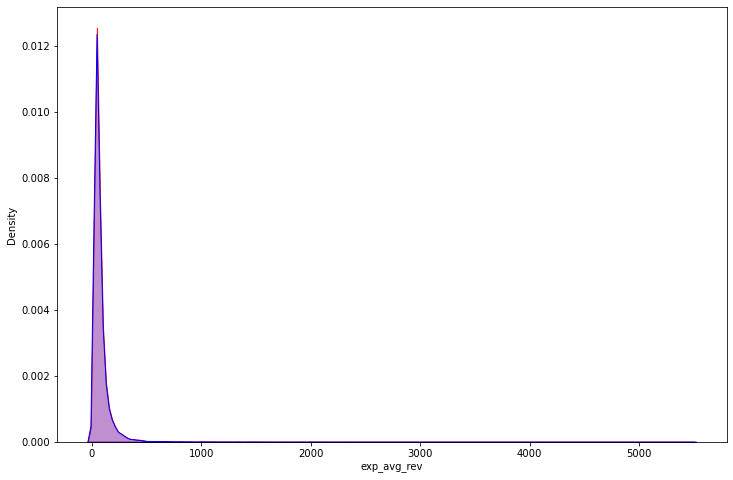

In [21]:
# density plot of actual vs expected distribution of average transaction value 
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))

fig = sns.kdeplot(summary_data['exp_avg_rev'], shade=True, color="r")
fig = sns.kdeplot(summary_data['monetary_value'], shade=True, color="b")
plt.show()

In [22]:
# calculate CLV for future 30 years
annual_rate = 0.1
monthly_rate = (1+annual_rate)**(1/12)-1 # convert annual rate to monthly rate
lifetime_in_years = 30
lifetime_in_month = lifetime_in_years*12 # convert years in months

summary_data['clv'] = ggf.customer_lifetime_value(bgf, summary_data['frequency'], summary_data['recency'], summary_data['T'], summary_data['monetary_value'], time=lifetime_in_month, freq='D', discount_rate=monthly_rate)
summary_data.head()

,Cust_ID,frequency,recency,T,monetary_value,condit_prob_alive,predict_purchases,exp_avg_rev,clv
0,22120,1.0,726.0,1114.0,13.950000,0.773238,4.92,19.369841,37.537844
2,29278,6.0,1470.0,1492.0,41.433333,0.921728,18.85,42.319261,326.612079
4,51943,1.0,68.0,2208.0,23.950000,0.238740,1.00,29.324611,10.954454
5,53281,3.0,464.0,2374.0,74.550000,0.091178,0.81,76.270437,23.669034
6,55012,1.0,360.0,2202.0,46.950000,0.439567,1.84,52.220582,35.989590


The average CLV is: 

In [23]:
# calculate average CLV
summary_data['clv'].mean()

273.9697188086635